In [10]:
import datetime as dt

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt

In [60]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)

In [11]:
import wmfdata as wmf
from wmfdata.utils import sig_figs

In [4]:
FILE = "metrics/metrics.tsv"

# Data loading and transformation

In [5]:
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Calculate existing active editors and insert in a logical position
ae_idx = metrics.columns.get_loc("active_editors")
eae_vals = metrics["active_editors"] - metrics["new_active_editors"] - metrics["second_month_active_editors"]
metrics.insert(ae_idx + 1, "existing_active_editors", eae_vals)

# Calculate total mobile edits and insert
mwe_idx = metrics.columns.get_loc("mobile_web_edits")
me_vals = metrics["mobile_web_edits"] + metrics["mobile_app_edits"]
metrics.insert(mwe_idx, "mobile_edits", me_vals)

# Drop columns that aren't key metrics
metrics = metrics.drop(["mobile_web_edits", "mobile_app_edits"], axis=1)

metrics.tail()

,active_editors,existing_active_editors,new_active_editors,second_month_active_editors,total_edits,mobile_edits,nonbot_edits,new_editor_retention,uploads,data_edits,total_content,wikipedia_articles,files,wikidata_entities
month,,,,,,,,,,,,,,
2017-12-01,79558,61019.0,14387.0,4152.0,37358877.0,1021714.0,19926673.0,0.052366,522009,13933627,178512868.0,46968190.0,47518748.0,43888840.0
2018-01-01,84422,64391.0,16678.0,3353.0,39437710.0,1153243.0,20374752.0,0.077360,675791,9749202,180301255.0,47369882.0,48199383.0,44334692.0
2018-02-01,78963,59777.0,15052.0,4134.0,39574449.0,1011393.0,19934503.0,0.066922,725015,15704642,184123520.0,47533734.0,48939378.0,47026490.0
2018-03-01,86190,64218.0,17625.0,4347.0,43003671.0,1121184.0,25176956.0,NaN,809162,17996980,NaN,NaN,NaN,NaN
2018-04-01,83705,62907.0,16059.0,4739.0,34530321.0,1107284.0,20762284.0,NaN,634360,12851269,NaN,NaN,NaN,NaN


# Report

In [12]:
def fmt_num(x):
    if type(x) in (np.float64, np.int64):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def pct(n):
    return "{:.1%}".format(n)

def find_latest(ser):
    nn_ser = ser[~ser.isnull()]
    return nn_ser.index[-1].date()

def calc_rpt(ser):
    nn_ser = ser[~ser.isnull()]
    cur_mo = nn_ser.index[-1].date()
    cur = nn_ser[-1]
    mo_prev = nn_ser[-2]
    yr_prev = nn_ser[-13]
    mom_change = (cur / mo_prev) - 1
    yoy_change = (cur / yr_prev) - 1
    
    res = [cur_mo, cur, mom_change, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["latest_month", "value", "mom_change", "yoy_change"]
    )

In [13]:
metrics.apply(calc_rpt).transpose()

,latest_month,value,mom_change,yoy_change
active_editors,2018-04-01,"83,700",-2.9%,1.0%
existing_active_editors,2018-04-01,"62,900",-2.0%,2.8%
new_active_editors,2018-04-01,"16,100",-8.9%,-5.1%
second_month_active_editors,2018-04-01,"4,740",9.0%,0.3%
total_edits,2018-04-01,"34,500,000",-19.7%,9.5%
mobile_edits,2018-04-01,"1,110,000",-1.2%,30.1%
nonbot_edits,2018-04-01,"20,800,000",-17.5%,19.6%
new_editor_retention,2018-02-01,6.7%,-13.5%,11.2%
uploads,2018-04-01,"634,000",-21.6%,1.7%
data_edits,2018-04-01,"12,900,000",-28.6%,47.1%


# Graphs

In [46]:
type(metrics.index)

pandas.core.indexes.datetimes.DatetimeIndex

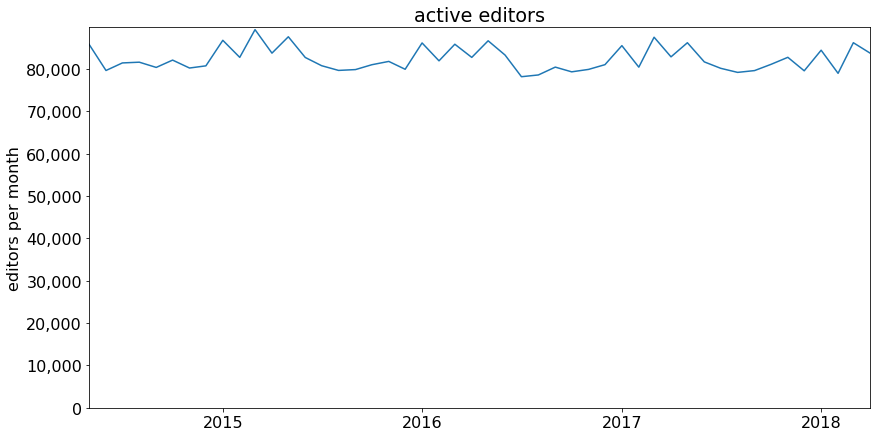

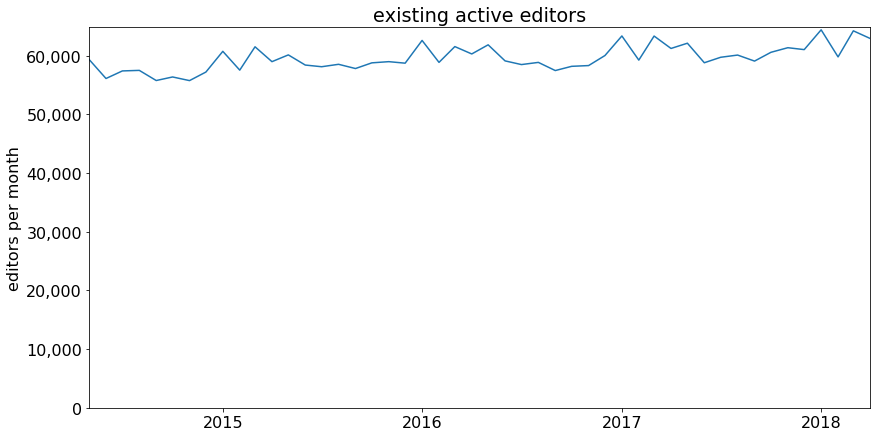

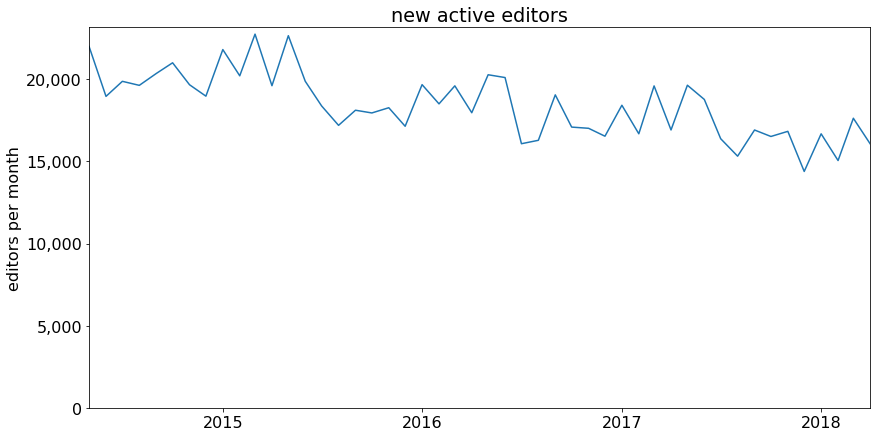

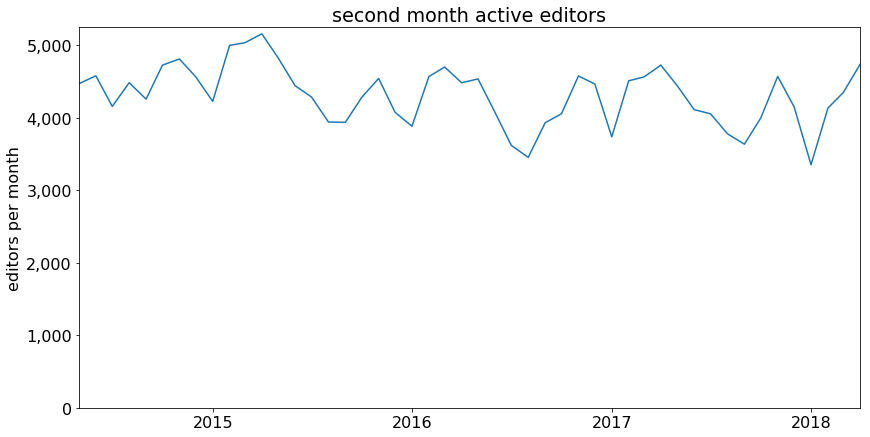

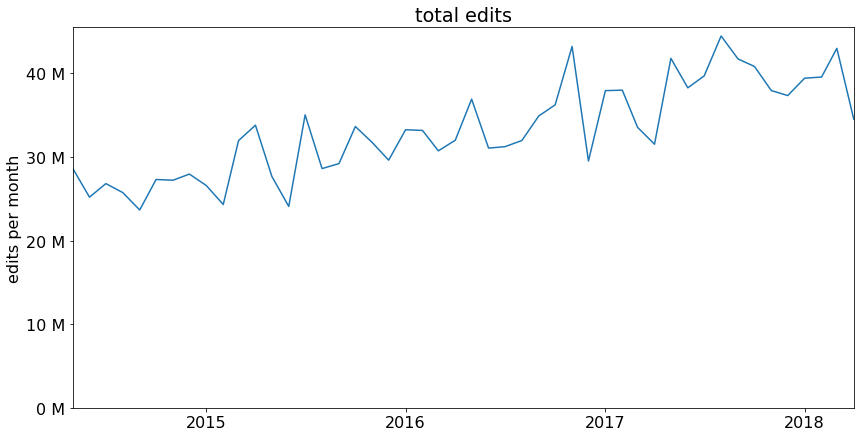

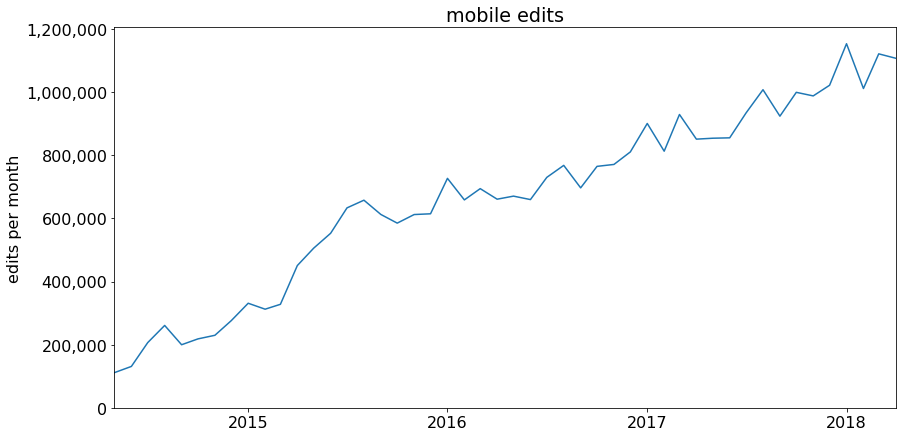

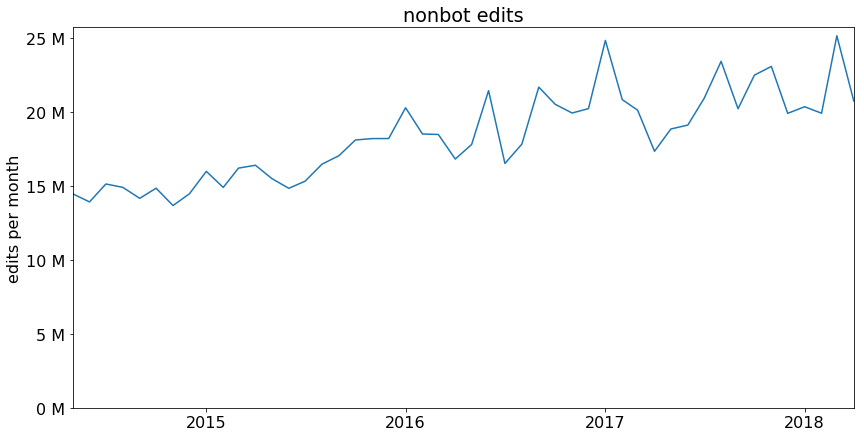

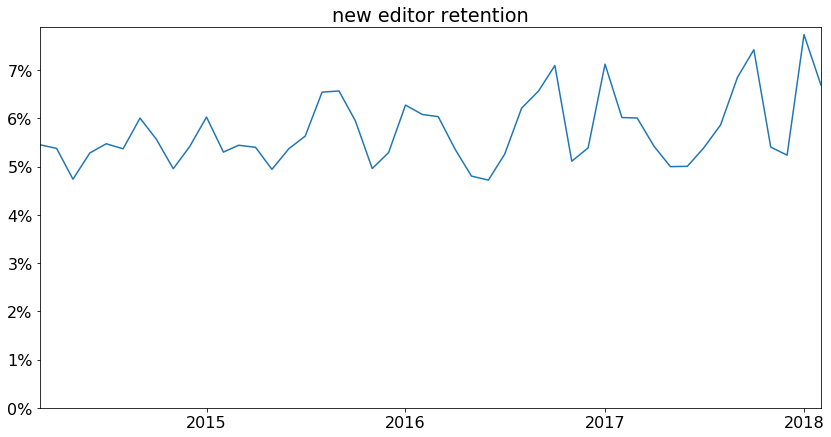

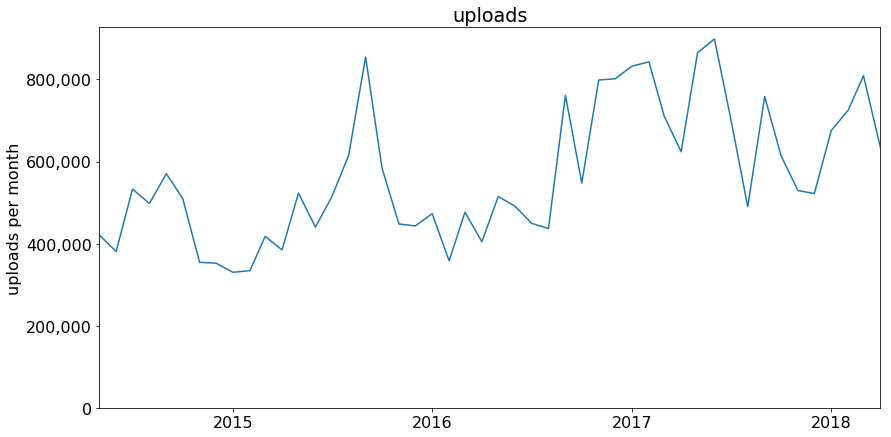

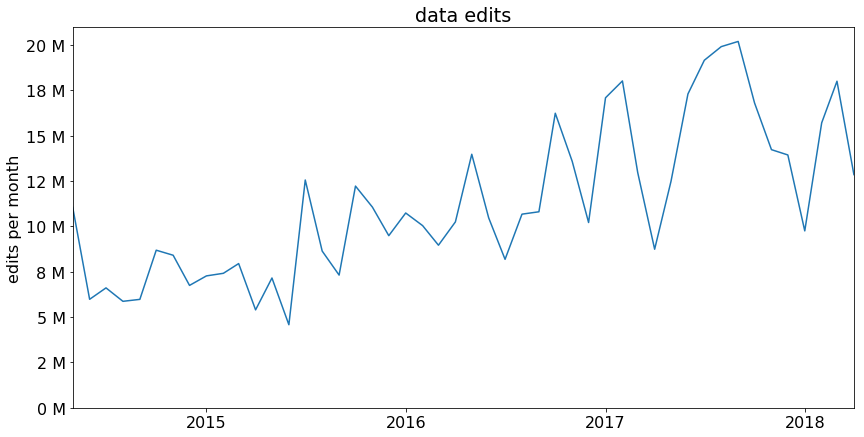

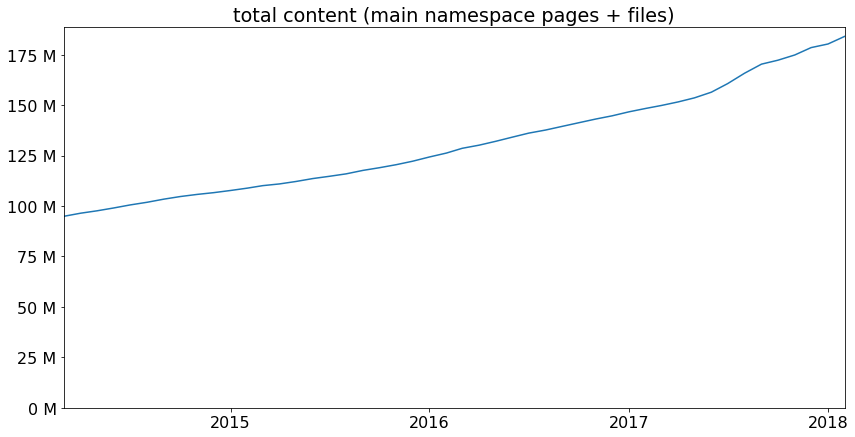

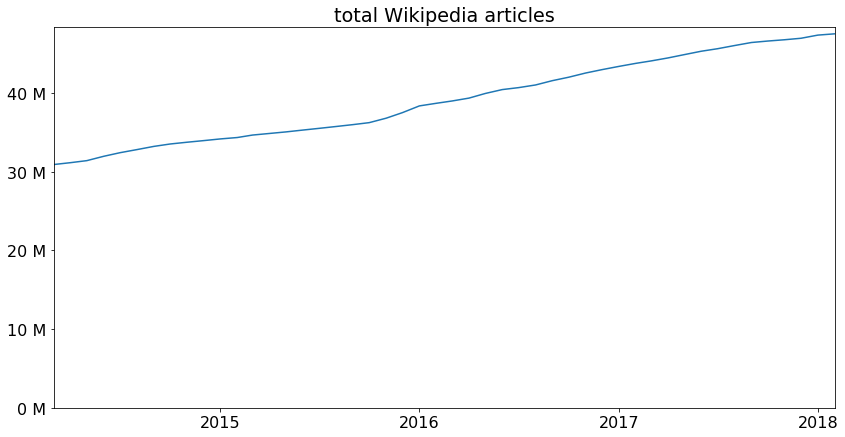

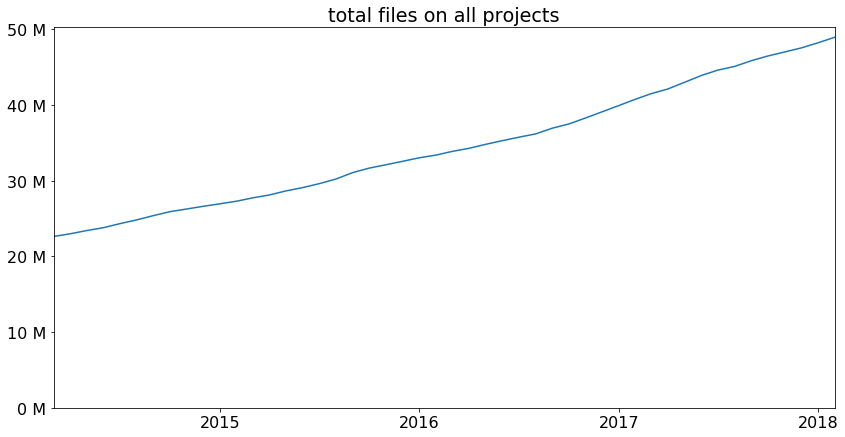

In [ ]:
def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

M_fmt = mpl.ticker.FuncFormatter(M_str)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1, decimals=0)

comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "total_content": {
        "y_fmt": M_fmt,
        "title": "total content (main namespace pages + files)"
    },
    "wikipedia_articles": {
        "y_fmt": M_fmt,
        "title": "total Wikipedia articles"
    },
    "files": {
        "y_fmt": M_fmt,
        "title": "total files on all projects"
    },
    "wikidata_entities": {
        "y_fmt": M_fmt,
        "title": "Wikidata entities"
    }
}

for name, col in metrics.iteritems():
    cfg = graph_cfg[name]
    plt.figure()

    end = find_latest(col)
    start = end - relativedelta(months = 47)
    plt.plot(col[start:end])

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.gca().xaxis.set_major_locator(mpl.dates.YearLocator())
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
        
    plt.ylim(ymin=0)
    plt.autoscale(enable=True, axis="x", tight=True)